### RANSAC(RANdom SAmple Consensus)
RANSAC은 인라이어(inlier)와 아웃라이어(outlier)가 혼합되어 있는 샘플 집합이 주어진 상황에서 인라이어를 찾아 어떤 모델을 적용시키는 일반적인 기법이다. 다만, 무작위로 수를 생성해 인라이어 군집을 찾아내는 과정을 반복해서 임의성을 지닌다.

RANSAC은 에지의 집합에서 직선을 찾아내는 일에 도입해 쓰기도 하는데 이때 에지 화소의 집합이 샘플 집합이 되고, 모델은 직선의 방정식 y=ax+b 에서 a와 b를 예측하는 모델이다.

RANSAC의 원리는 다음과 같다.
1. 에지 화소 두 개를 임의로 선택한다.
2. 이 두 점으로 직선의 방정식을 계산한다.  
$$
when \ y=ax+c, for \ (x1,y1), \ (x2,y2)
$$

$$
a = \frac{y_{2}-y_{1}}{x_{2}-x_{1}}
$$

$$
c = y_{1}-ax_{1}
$$
3. 에지인 화소 중 이 직선과 거리가 허용오차 d 이내인 점을 inlier로 한다.  
a'x+b'y+c'=0을 만족하는 직선을 때, 새로운 x_{n}과 y_{n}에 대해 직선과의 거리는
$$
distance=\frac{\begin{vmatrix}a'x_{n}+b'y_{n}+c' \end{vmatrix}}{\sqrt{a'^{2}+b'^{2}}}
$$
4. 1~3을 n번 반복하며 inlier의 개수가 가장 큰 직선을 취한다.
5. 이 직선을 최소자승법을 이용해 최적화 한다.

### 코드 구현
이전에 작성한 util에서 canny함수를 사용해 영상을 이진화 한다.

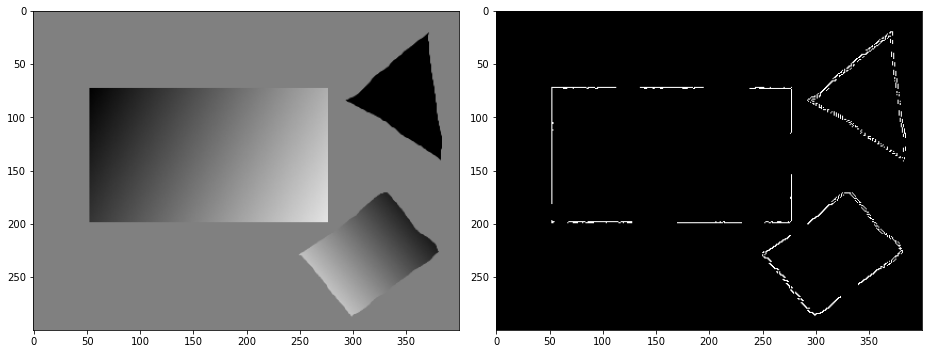

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from util import *
img = cv2.imread('./data/pic6.png')

fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

canny_img = canny(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),30,70)
plt.subplot(122)
plt.imshow(canny_img,cmap='gray')
fig.tight_layout()
plt.show()

먼저 edge인 픽셀에 대해 랜덤으로 2개의 점을 선택하고 이를 이용해 직선의 방정식을 도출해야한다.  
직선의 거리를 계산하기 위해 먼저 ax+by+c = 0 식을 만족 하는 (a,b,c)를 return 하도록 함수를 작성했다.  
여기서 b는 1로 고정시켰다.

In [2]:
def make_line(y_idxs,x_idxs):
    x1,x2,y1,y2=(0,0,0,0)
    while x1 ==x2 or y1 ==y2:
        ch_idxs = np.random.choice(len(y_idxs), 2, replace=False)
        y1 = y_idxs[ch_idxs[0]]
        x1 = x_idxs[ch_idxs[0]]
        y2 = y_idxs[ch_idxs[1]]
        x2 = x_idxs[ch_idxs[1]]
    slope = (y2-y1) /(x2-x1)
    c = -(y1-(x1*slope))
    return (-1*slope,1,c) # ax+by+c=0

In [3]:
y_idxs,x_idxs= np.where(canny_img) # canny_img에서 True인 배열의 인덱스를 반환한다.
m_slope,one,m_bias = make_line(y_idxs,x_idxs)
print(m_slope,one,m_bias)

0.08256880733944955 1 -208.1559633027523


다음으로 점과 직선의 거리를 구하는 수식을 이용한다. for문을 이용하기 보다 numpy의 함수를 이용하는 방식이 빠르므로 numpy 함수를 이용해 구현했다.

In [4]:
def cal_distance(a,b,c,xx,yy):
    return abs(a*xx+b*yy+c)/np.sqrt(a**2+b**2)

x_range = np.arange(canny_img.shape[1])
y_range = np.arange(canny_img.shape[0])
xx,yy = np.meshgrid(x_range,y_range)

cal_distance(m_slope,one,m_bias,xx,yy)

array([[207.45000808, 207.3677193 , 207.28543052, ..., 174.78136341,
        174.69907463, 174.61678586],
       [206.45339955, 206.37111077, 206.288822  , ..., 173.78475488,
        173.70246611, 173.62017733],
       [205.45679102, 205.37450225, 205.29221347, ..., 172.78814636,
        172.70585758, 172.6235688 ],
       ...,
       [ 88.54272459,  88.62501337,  88.70730215, ..., 121.21136926,
        121.29365804, 121.37594681],
       [ 89.53933312,  89.6216219 ,  89.70391067, ..., 122.20797779,
        122.29026656, 122.37255534],
       [ 90.53594165,  90.61823042,  90.7005192 , ..., 123.20458631,
        123.28687509, 123.36916387]])

지정한 d이내의 오차를 갖으며 edge인 픽셀에 대해 idxs의 목록을 받으려면 다음과 같이 작성하면 된다.

In [5]:
d = 2

idxs = np.where(np.logical_and(cal_distance(m_slope,one,m_bias,xx,yy)<d,canny_img))

In [6]:
idxs

(array([179, 179, 180, 180, 180, 180, 181, 181, 182, 182, 182, 182, 182,
        183, 183, 184, 184, 184, 185, 186, 187, 198, 198, 198, 198, 198,
        198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198,
        198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199,
        199, 199, 199, 199, 199, 199, 199, 199, 199, 199], dtype=int64),
 array([338, 341, 317, 339, 341, 342, 315, 316, 312, 313, 314, 315, 341,
        311, 312, 277, 310, 311, 277, 277, 277,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127,  87,  88,  89,  90,
         91, 103, 115, 116, 119, 123, 124, 125, 126, 127], dtype=int64))

마지막으로 최소 자승법을 이용해 최적의 직선을 찾고 ax+y+c=0을 만족하기 위해 -1을 곱한 결과를 return 하는 함수를 작성한다.

In [7]:
def Least_square(idxs):
    '''
    :param idxs: (y_idxs,x_idxs)
    :return: [a,b]^T = (A^T A)^-1 A^T B    where, ax+b=y and A=((x1,1),(x2,1),(x3,1),...), B=((y1),(y2),...)
    '''
    y_idxs,x_idxs = idxs
    x_idxs = np.expand_dims(x_idxs,-1)  # (len,1)
    y_idxs = np.expand_dims(y_idxs,-1)  # (len,1)
    A = np.concatenate([x_idxs,np.ones_like(x_idxs)],-1) # (len,2)
    slope,bias = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.transpose(),A)),A.transpose()),y_idxs)
    return slope*-1,bias*-1



In [8]:
print(Least_square(idxs))

(array([0.07913282]), array([-207.12125678]))


ransac의 전체적인 함수는 다음과 같이 작성했다. 주석을 참고하면 된다.

In [9]:
# ax+y+c<1를 만족하는 직선을 이미지내에 그린다.완벽하게 0을 만족하지 않는 경우도 있기 때문에 1로 설정했다.
def draw_line(m_slope,m_bias,xx,yy): 
    return np.where(abs(xx*m_slope+yy+m_bias)<1,255,0)

def ransac(img,n=50,d=2,return_image=True):
    '''
    :param img: binary(recommand)
    :param n: number of iteration
    :param d: tolerance
    :param return_image:
        True: you can get a straight line image
        False: you can get Linear equation
    :return:
    '''
    if len(img.shape)==2:
        h,w=img.shape
    else:
        h,w,c=img.shape

    y_idxs,x_idxs= np.where(img)

    x_range = np.arange(w)
    y_range = np.arange(h)
    xx, yy = np.meshgrid(x_range, y_range)

    max_line=[0,0,0,0]

    # search model
    for i in range(n):
        m_slope,one,m_bias = make_line(y_idxs,x_idxs)
        temp_idxs = np.where(np.logical_and(cal_distance(m_slope,one,m_bias,xx,yy)<d,img))
        if len(temp_idxs[0])<2: # 2개 이상이어야 직선의 방정식을 세울 수 있다. 
            continue
        if max_line[0]<len(temp_idxs[0]): # 현재 찾은 직선보다 더 많은 점들을 포함하는 경우 교체한다.
            max_line = [len(temp_idxs[0]),m_slope,m_bias,temp_idxs]

    # optimization line
    optimal_param = Least_square(max_line[-1])

    if return_image:
        original_line = draw_line(max_line[1],max_line[2],xx,yy)
        optimal_line = draw_line(optimal_param[0],optimal_param[1],xx,yy)
        return original_line,optimal_line
    else:
        optimal_line = [max_line[0],optimal_param[0],optimal_param[1],max_line[3]]
        return max_line,optimal_line

직선의 이미지를 원본에 그리기 위해서 다음과 같은 함수를 추가로 작성했다.

In [10]:
def draw_line_in_image(line,img):
    if len(img.shape) is not 2:
        print("Shape of input image must have 2, but this input image have shape of {}".format(len(img.shape)))
        return None
    r = np.expand_dims(np.clip(line+img,0,255),-1)
    g = np.expand_dims(np.where(line,0,img),-1)
    b = g
    ret = np.concatenate([r,g,b],-1)
    plt.imshow(ret)

ransac은 랜덤으로 선택하는 부분 때문에 n이 작으면 작을 수록 실행때마다 다른 값이 나올 확률이 높아진다.
다음의 결과는 최적화가 되기전과 최적화가 된 직선, n이 50인 경우와 5인 경우에 대한 결과이다

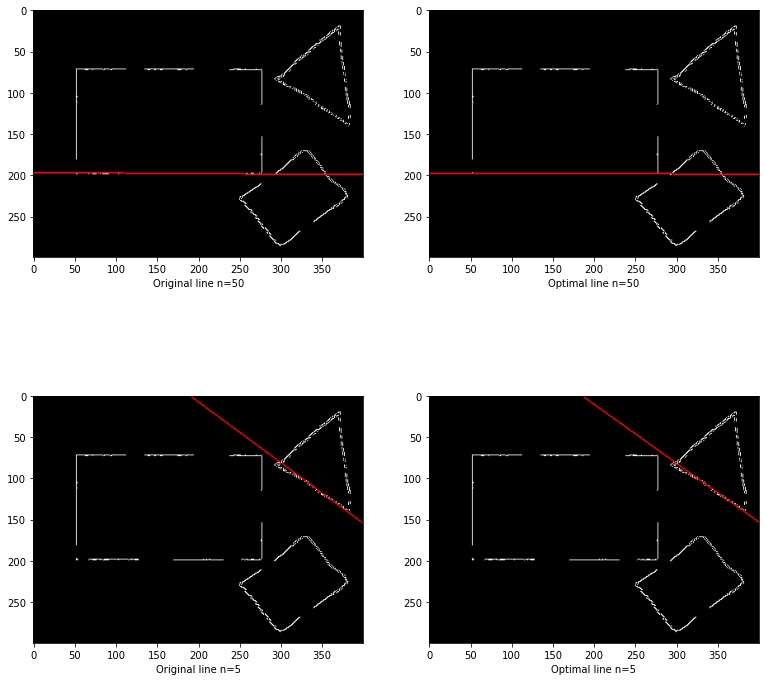

In [11]:
fig = plt.figure(figsize=(13,13))
ori_line,optimal_line = ransac(canny_img)
plt.subplot(221)
plt.xlabel('Original line n=50')
draw_line_in_image(ori_line,canny_img)
plt.subplot(222)
plt.xlabel('Optimal line n=50')
draw_line_in_image(optimal_line,canny_img)

ori_line,optimal_line = ransac(canny_img,n=5)
plt.subplot(223)
plt.xlabel('Original line n=5')
draw_line_in_image(ori_line,canny_img)
plt.subplot(224)
plt.xlabel('Optimal line n=5')
draw_line_in_image(optimal_line,canny_img)
plt.show()

아래의 경우 최적화 전과 후가 잘 차이가 나지 않지만 위의 결과의 경우 좀더 많은 직선을 포함하도록 최적화된 것을 볼 수 있다.